In [1]:
import json
import pandas as pd
from skimage.io import imread
import cv2
from tqdm import tqdm, tqdm_notebook
import pythreshold
from pythreshold.local_th import wolf, feng, niblack, bernsen
from scipy.spatial.distance import cdist

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Approach summary

My approach is to binarize image, then  to find edges by opencv function cv2.findCountors, after that for every point in the input crop's polygon find the closest point from these opencv's countors. Also, for more flexibility, I added 2 points for every edge.

## Reading data

In [2]:
DATA_FOLDER = "./tocorrect/"
data = pd.read_csv("./tocorrect/crop_regions.csv")

In [3]:
def str_to_dict(s):
    return json.loads(s.replace("u'", "'").replace("\'", "\""))

In [4]:
data["crop_regions"] = data["crop_regions"].apply(str_to_dict)

In [5]:
data

receipt_id                  file_path  \
0      3487830  receipt_files/3487830.jpg   
1      3490860  receipt_files/3490860.jpg   
2      3491247  receipt_files/3491247.jpg   
3      3487613  receipt_files/3487613.jpg   
4      3488933  receipt_files/3488933.jpg   
5      3488767  receipt_files/3488767.jpg   
6      3490818  receipt_files/3490818.jpg   
7      3488055  receipt_files/3488055.jpg   
8      3489461  receipt_files/3489461.jpg   
9      3489909  receipt_files/3489909.jpg   
10     3490501  receipt_files/3490501.jpg   

                                         crop_regions  
0   [[{'y': 46, 'x': 1032}, {'y': 1212, 'x': 995},...  
1   [[{'y': 288, 'x': 531}, {'y': 285, 'x': 731}, ...  
2   [[{'y': 393, 'x': 546}, {'y': 383, 'x': 669}, ...  
3   [[{'y': 222, 'x': 1927}, {'y': 938, 'x': 1891}...  
4   [[{'y': 155, 'x': 1343}, {'y': 177, 'x': 1667}...  
5   [[{'y': 623, 'x': 795}, {'y': 724, 'x': 866}, ...  
6   [[{'y': 279, 'x': 1238}, {'y': 1701, 'x': 1234...  
7   [[{'y': 91, 'x': 1065}, {'y': 108, 'x': 2704},...  
8   [[{'y': 39, 'x': 395}, {'y': 256, 'x': 392}, {...  
9   [[{'y': 239, 'x': 1529}, {'y': 2048, 'x': 1536...  
10  [[{'y': 405, 'x': 686}, {'y': 363, 'x': 1986},...

## Helper image processing functions

In [58]:
def find_closest(old_x, old_y, possible_x, possible_y, crop_height, crop_width, n_closest=1, max_abs_diff=30):
    """
    Output mean of n_closest data points from [possible_x, possible_y] points for every [old_x, old_y] point.
    """
    
    possible_x = np.array(possible_x)
    possible_y = np.array(possible_y)
    
    old_points = np.array(list(zip(old_x, old_y)))
    possible_points = list(zip(possible_x, possible_y))
    dists = cdist(old_points, possible_points)
    new_indecies = np.argpartition(dists, n_closest, axis=1)[:, :n_closest]
    if n_closest == 1:
        new_indecies = np.expand_dims(new_indecies, 1)
    new_x = [possible_x[closest_ind].mean() for closest_ind in new_indecies]
    new_y = [possible_y[closest_ind].mean() for closest_ind in new_indecies]
    
    # do not change the point if it lies on the bound of image
    for i in range(len(new_x)):
        if old_line_x[i] == crop_width or old_line_y[i] == crop_height:
            new_x[i] = old_x[i]
            new_y[i] = old_y[i]
            
        # or absolute of difference is too big
        if np.abs(new_x[i] - old_x[i]) > max_abs_diff or np.abs(new_y[i] - old_y[i]) > max_abs_diff:
            new_x[i] = old_x[i]
            new_y[i] = old_y[i]
        
    return new_x, new_y

In [54]:
def apply_canny(crop, ratio=0.5):
    """
    Apply canny edges detector for input image, adjust threshold using otsu algorithm.
    """
    
    high_thresh, thresh_im = cv2.threshold(crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = ratio * high_thresh
    canny = cv2.Canny(crop, lowThresh, high_thresh)
    return canny

In [55]:
def increase_number_of_points_in_polygon(points, n_extra_points=2):
    """
    Add extra n_extra_points points for every edge in input polygon.
    """
    
    n_parts = n_extra_points + 2
    new_points = list()
    for i in range(1, len(points)):
        for j in range(n_parts + 1):
            new_points.append((points[i] * j + points[i-1] * (n_parts - j)) / n_parts)
    return new_points

## Running pipeline

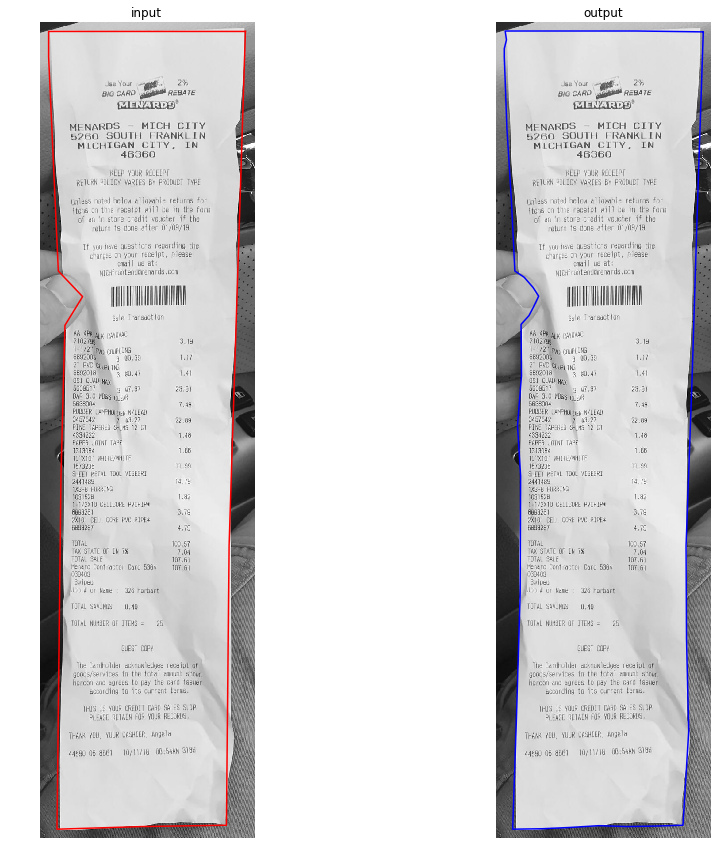

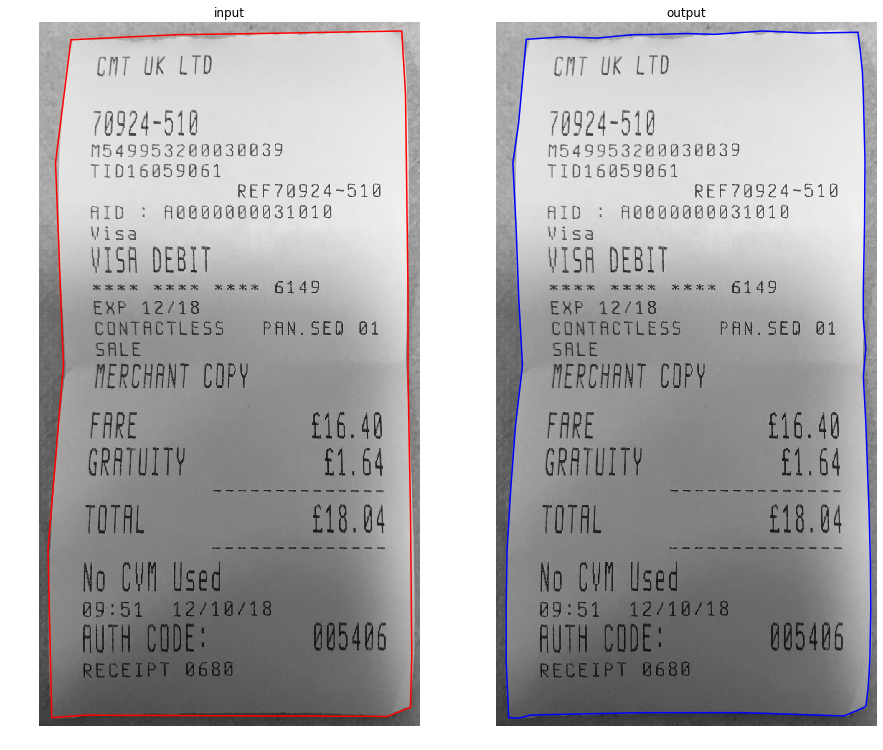

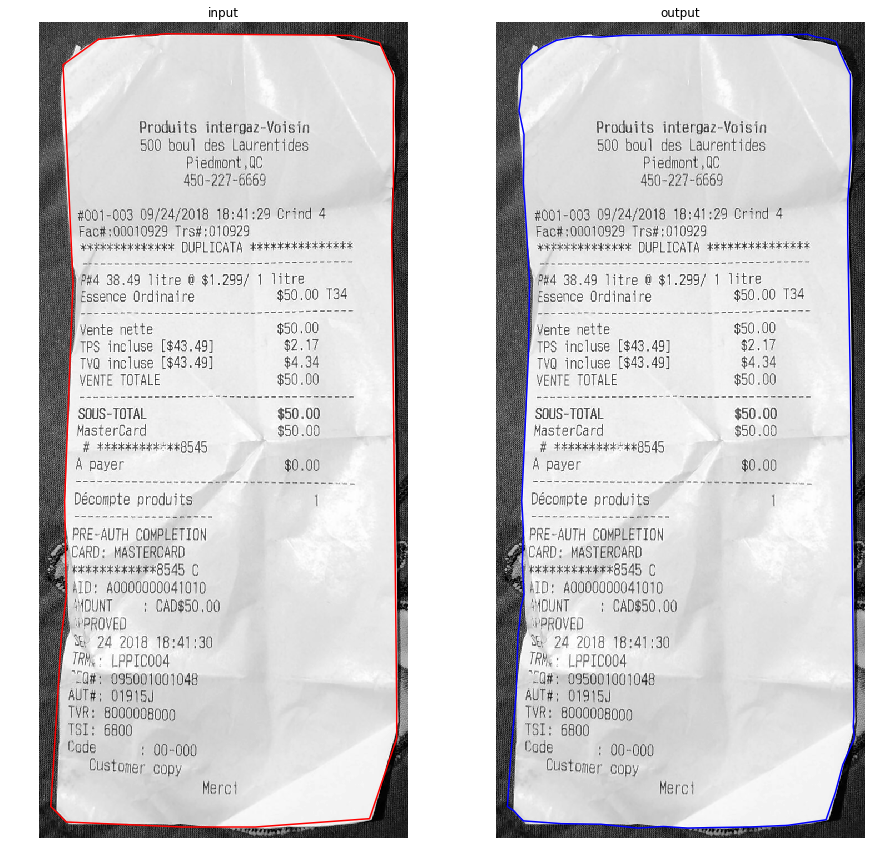

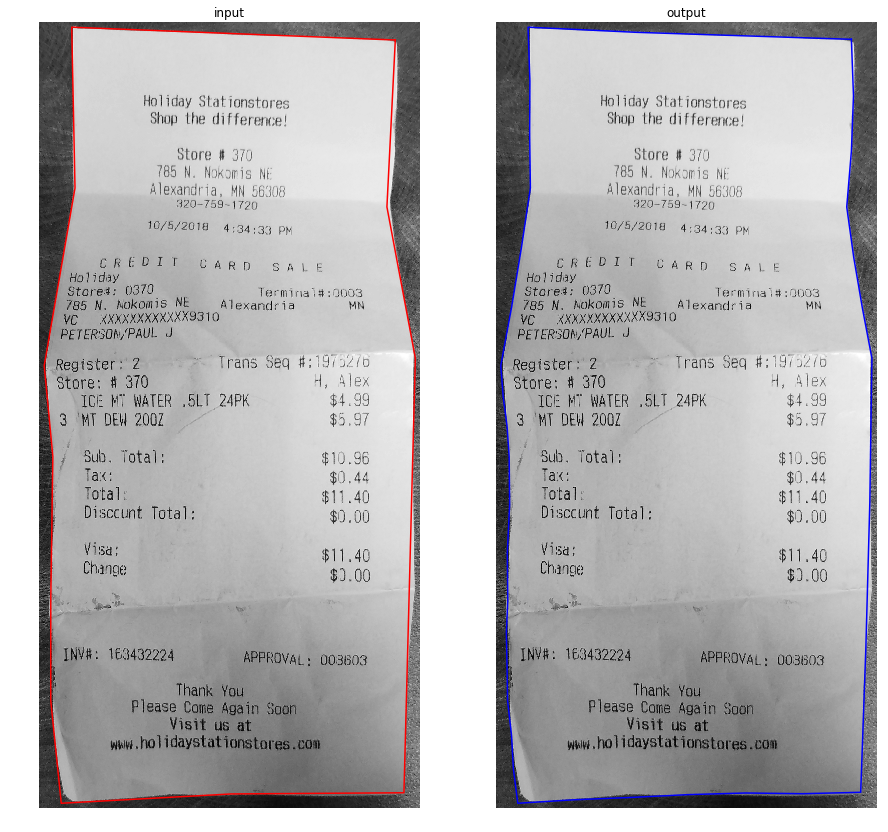

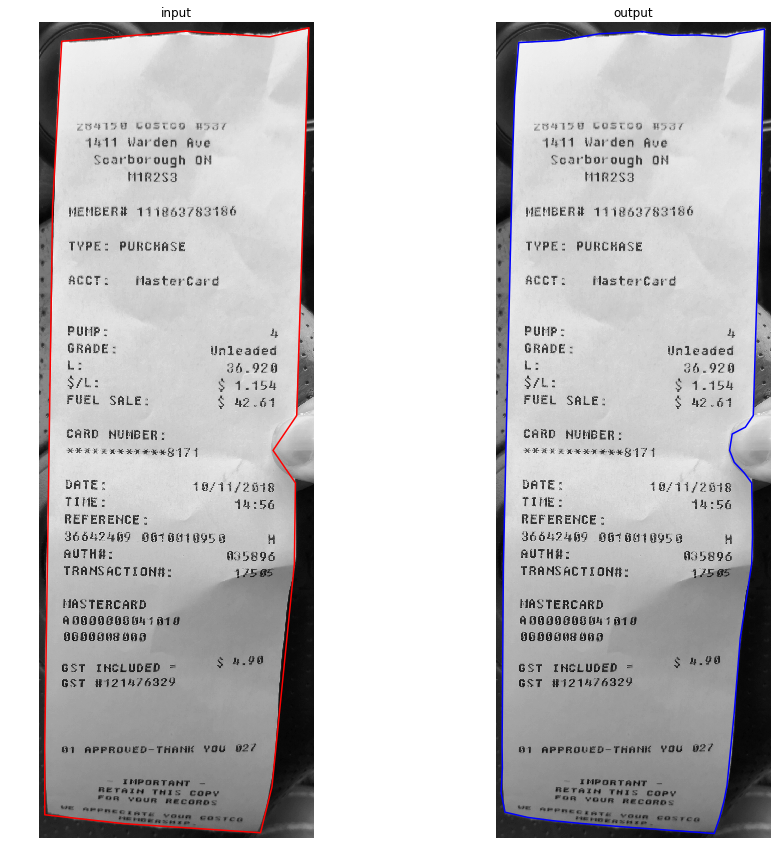

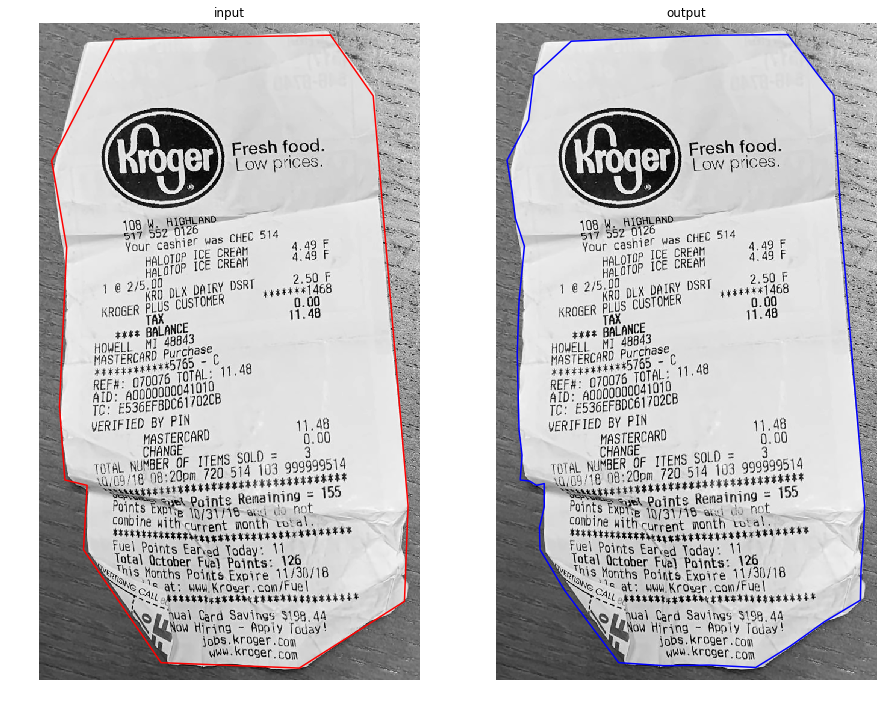

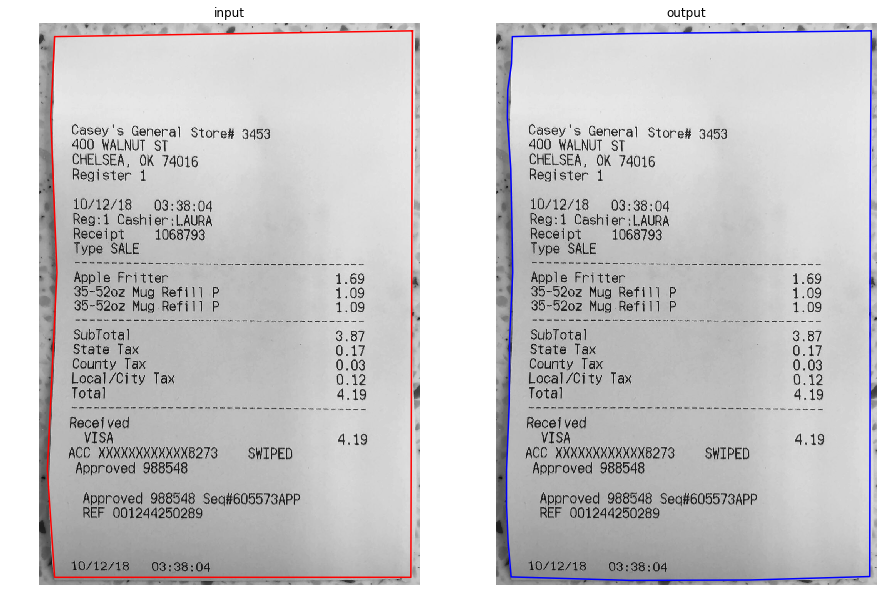

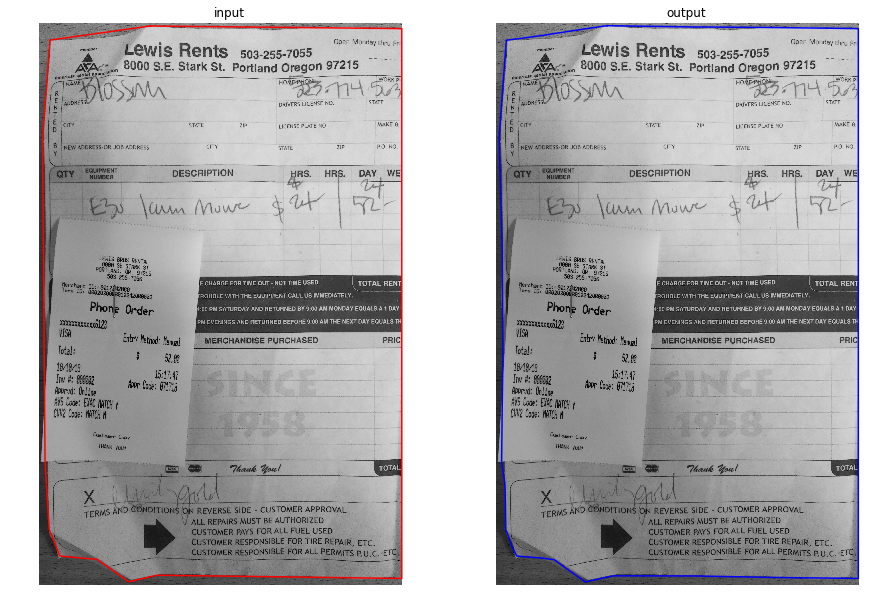

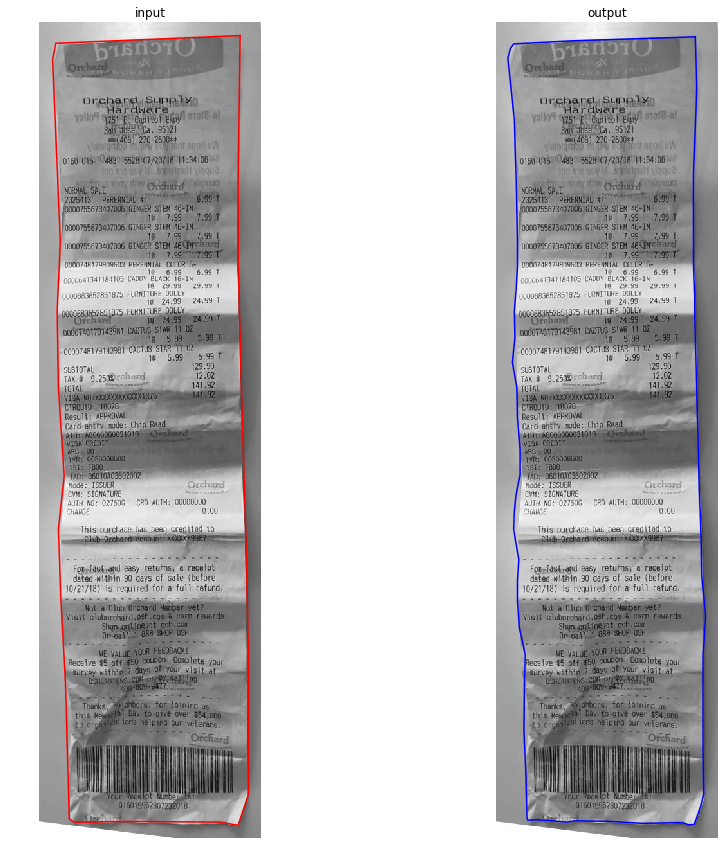

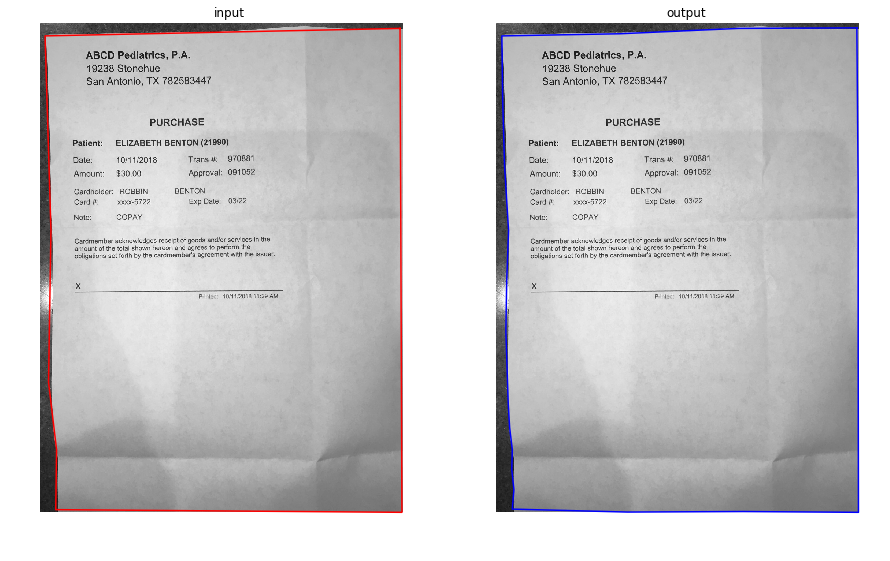

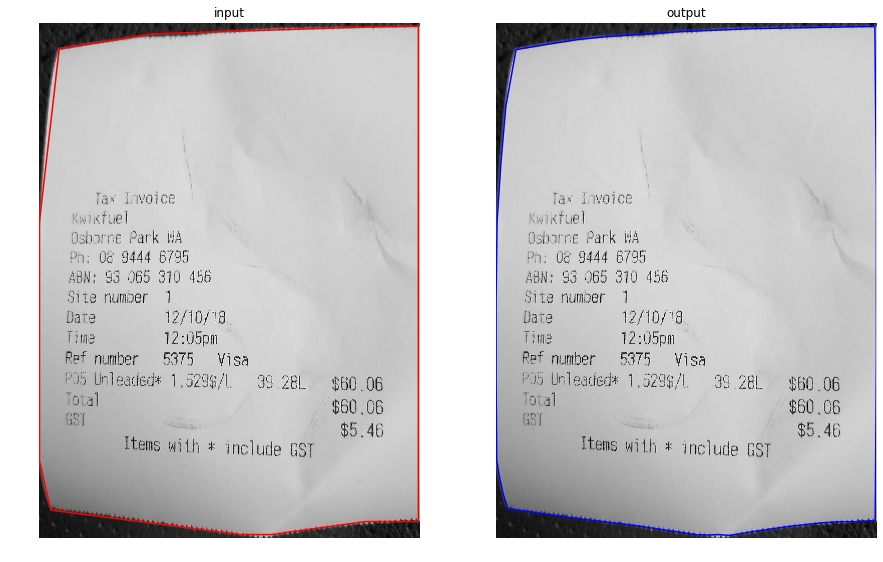

In [73]:
offset = 20
for i, row in data.iterrows():
    img = cv2.imread(DATA_FOLDER + row["file_path"], 0)
    
    line_x = [d["x"] for d in row["crop_regions"][0]]
    line_x.append(line_x[0])
    
    line_y = [d["y"] for d in row["crop_regions"][0]]
    line_y.append(line_y[0])
    
    crop = img[max(min(line_y) - offset, 0) : min(max(line_y) + offset, img.shape[0]), 
               max(min(line_x) - offset, 0) : min(max(line_x) + offset,  img.shape[1])].copy()
    crop = cv2.fastNlMeansDenoising(crop,None, 7, 7, 3)
    
    crop_line_x = [x - max(min(line_x) - offset, 0) for x in line_x]
    crop_line_y = [y - max(min(line_y) - offset, 0) for y in line_y]
    
    bin_crop = np.array(crop >= bernsen.bernsen_threshold(crop), dtype=np.uint8)
    contours, hierarchy = cv2.findContours(bin_crop * 255, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    out = cv2.drawContours(np.zeros_like(crop), contours, -1, 255, 1)
    possible_y, possible_x = np.nonzero(out)
    
    old_line_y = increase_number_of_points_in_polygon(crop_line_y, 1)
    old_line_x = increase_number_of_points_in_polygon(crop_line_x, 1)
    new_x, new_y = find_closest(old_line_x, old_line_y, possible_x, possible_y, 
                                len(crop), len(crop[0]), n_closest=1)
    
    f, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(crop, cmap="gray")
    axs[0].plot(crop_line_x, crop_line_y, color="red")
    axs[0].axis("off")
    axs[0].set_title("input")
    
    axs[1].imshow(crop, cmap="gray")
    axs[1].plot(new_x, new_y, color="blue")
    axs[1].axis("off")
    axs[1].set_title("output")
    plt.show()

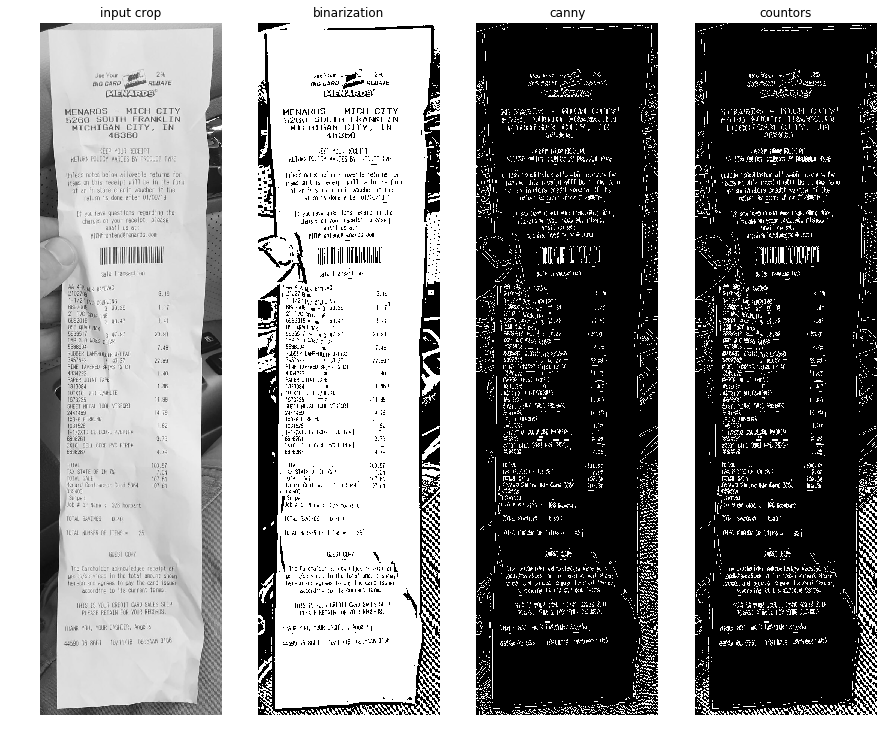

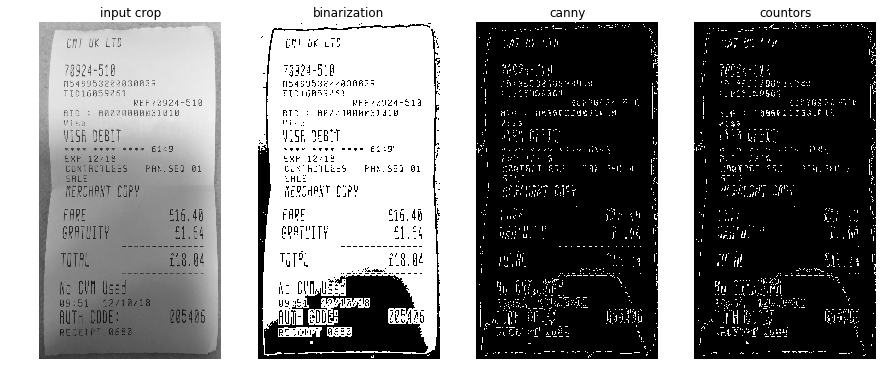

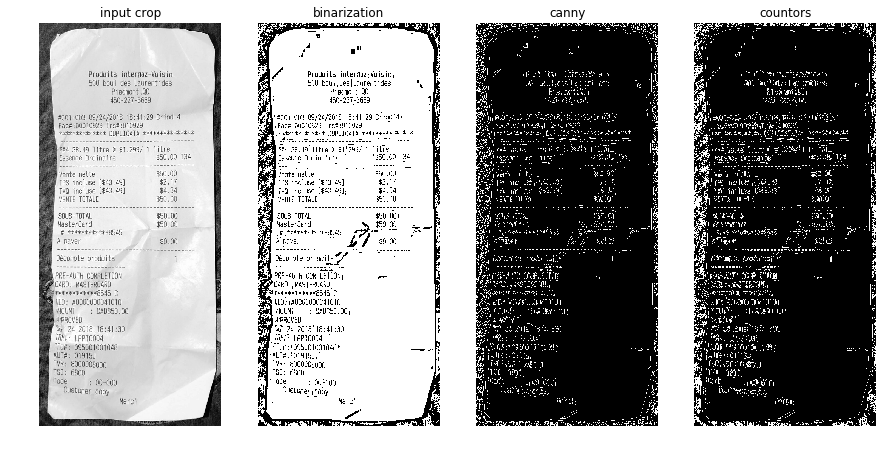

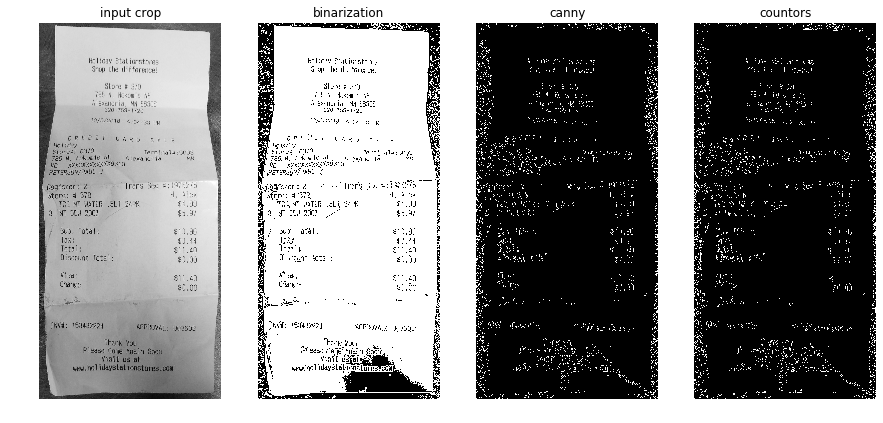

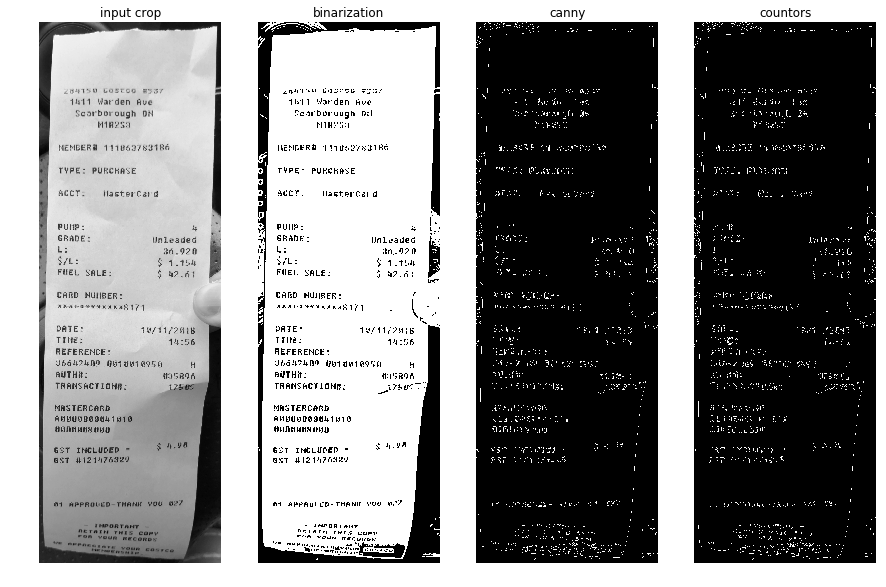

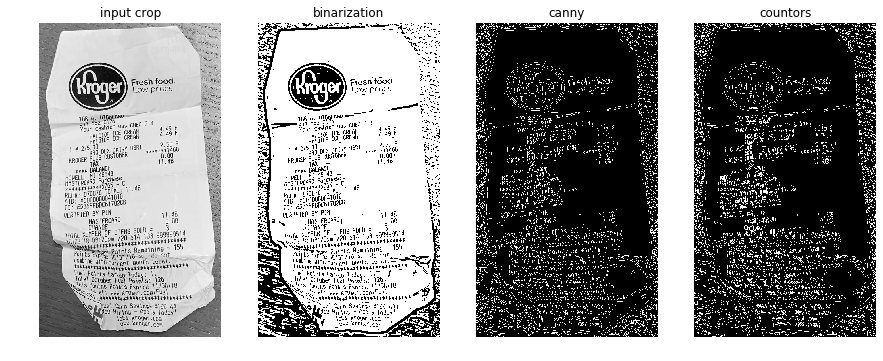

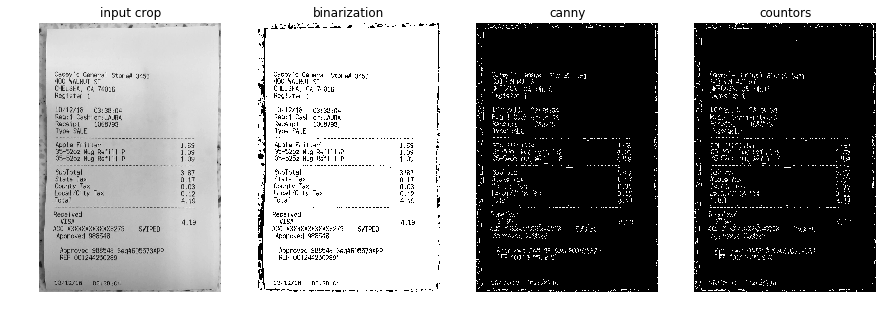

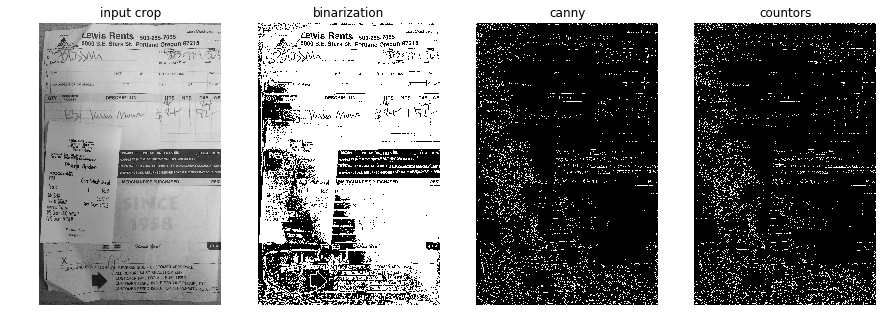

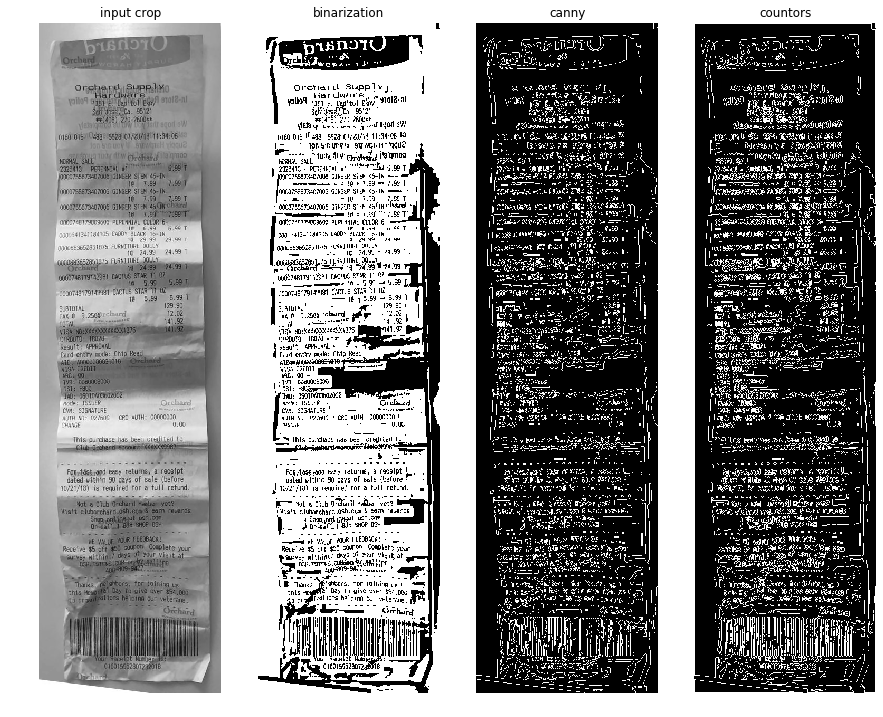

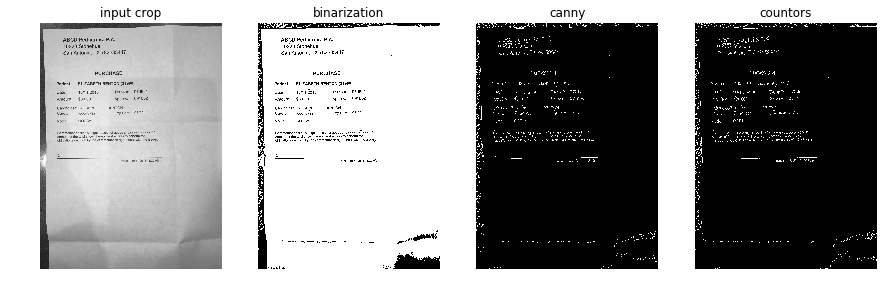

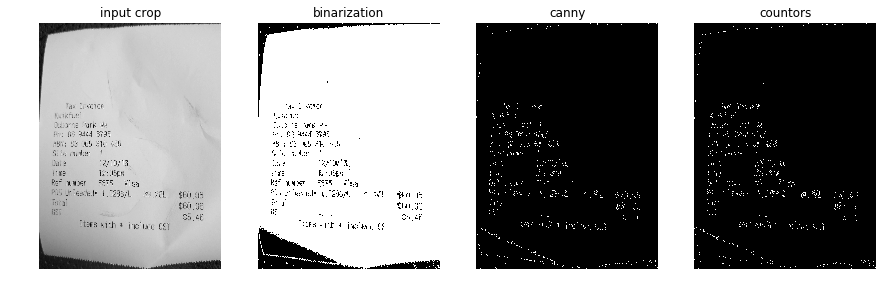

In [74]:
offset = 20
for i, row in data.iterrows():
    img = cv2.imread(DATA_FOLDER + row["file_path"], 0)
    
    line_x = [d["x"] for d in row["crop_regions"][0]]
    line_y = [d["y"] for d in row["crop_regions"][0]]
    crop = img[max(min(line_y) - offset, 0) : min(max(line_y) + offset, img.shape[0]), 
               max(min(line_x) - offset, 0) : min(max(line_x) + offset,  img.shape[1])].copy()
    crop = cv2.fastNlMeansDenoising(crop,None, 7, 7, 3)
    
    bin_crop = np.array(crop >= bernsen.bernsen_threshold(crop), dtype=np.uint8)
    contours, hierarchy = cv2.findContours(bin_crop * 255, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    out = cv2.drawContours(np.zeros_like(crop), contours, -1, 255, 1)
    
    f, axs = plt.subplots(1, 4, figsize=(15, 15))
    
    axs[0].imshow(crop, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title("input crop")
    
    axs[1].imshow(bin_crop, cmap="gray")
    axs[1].axis("off")
    axs[1].set_title("binarization")
    
    axs[2].imshow(apply_canny(bin_crop), cmap="gray")
    axs[2].axis("off")
    axs[2].set_title("canny")
    
    axs[3].imshow(out, cmap="gray")
    axs[3].set_title("countors")
    axs[3].axis("off")
    plt.show()